<h1><center>🏠🏠House Rent Prediction 🏠🏠</center></h1> 

## 📋 เกี่ยวกับชุดข้อมูล
ใช้ชุดข้อมูลจากเว็บไซต์ Kaggle ซึ่งเกี่ยวกับข้อมูลที่อยู่อาศัยที่สามารถให้เช่าอยู่ได้ในประเทศอินเดีย [Linked to Kaggle website](https://www.kaggle.com/datasets/iamsouravbanerjee/house-rent-prediction-dataset)

📑 ซึ่งในข้อมูลจะประกอบไปด้วย :
- `BHK`: จำนวนห้องนอนห้องนั่งเล่นเเละห้องครัวรวมกัน
- `Rent`: ค่าเช่าของห้อง
- `Size`: ขนาดของที่ห้อง (ตารางฟุต)
- `Floor`: ห้องที่สามารถเช่าได้อยู่ชั้นใดของที่อยู่อาศัยเเละมีทั้งหมดกี่ชั้น (เช่น :ชั้นล่างสุดจากทั้งหมด 2 ชั้น, ชั้น 3 จากทั้งหมด 5)
- `Area Type`: ขนาดพื้นที่คำนวนจาก (Carpet Area: พื้นที่สามารถปูพรมได้), (ฺBuild Area: Carpet Area + พื้นที่กำเเพง), (Super Area: Build Area + พื้นที่ส่วนอื่นๆ
- `Area Locality`: ใกล้กับสถานที่ใดบ้าง
- `City`: ที่อยู่ของที่อยู่อาศัย
- `Furnishing Status`: สถานะเฟอร์นิเจอร์ในห้องเช่า (ไม่มีเฟอร์นิเจอร์ ,มีบ้างเล็กน้อย ,มีเฟอร์นิเจอร์) 
- `Tenant Preferred`: ประเภทของผู้เช่าที่เจ้าของอนุญาตให้เช่า
- `Bathroom`: จำนวนห้องน้ำ
- `Point of Contact`: บุคคลที่สามารถติดต่อสอบถามเพิ่มเติมได้เกี่ยวกับการเช่าที่อยู่อาศัย

# 📚 Import Library


In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn2pmml import sklearn2pmml
from sklearn2pmml.pipeline import PMMLPipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler


# ✏️ Define Functions & Read Dataset

In [110]:
def shape(df,df_name):
    print(f'ขนาดข้อมูลของ : "{df_name}" = {df.shape}')

def vc(df, column, r=False):
    vc_df = df.reset_index().groupby([column]).size().to_frame('count')
    vc_df['percentage (%)'] = vc_df['count'].div(sum(vc_df['count'])).mul(100)
    vc_df = vc_df.sort_values(by=['percentage (%)'], ascending=False)
    if r:
        return vc_df
    else:
        print(f' จำนวนข้อมูลของ : "{column}"')
        display(vc_df)
def one_hot_encode(df, column):
    # Get one hot encoding of columns B
    one_hot = pd.get_dummies(df[column])
    # Drop column as it is now encoded
    df = df.drop(column,axis = 1)
    print(f"one hot encoded {column}")
    # Join the encoded df
    df = df.join(one_hot)
    return df
def trim(df):
    df.columns = df.columns.str.strip()
    df = df.drop_duplicates()
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ','_')
    df_obj = df.select_dtypes(['object'])
    df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    print("เเก้ไขชื่อคอลัมป์ทั้งหมดให้เป็นตัวพิมพ์เล็กเเละเเทนที่การเว้นวรรคด้วย underscore")
    print("ลบข้อมูลที่ซ้ำกันที่เป็นส่วนเกิน")
    return df
df = pd.read_csv("House_Rent_Dataset.csv")
shape(df,'df')
df.head()

ขนาดข้อมูลของ : "df" = (4746, 12)


,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


<br>

# 🧹 การ Clean ข้อมูล


In [111]:
# แก้ไขดัดแปลงข้อมูล.
shape(df,'df')
df2 = trim(df)
shape(df,'df')

# แก้ไขคอลัมป์ "floor"
df2 = df2.join(df2['floor'].str.split(' out of ', n=1, expand=True).rename(columns={0:'floor_level', 1:'total_floor'}))
df2['floor_level'] = df2.apply(lambda x: 0 if x['floor_level'] =='Ground' \
                               else ( -1 if x['floor_level'] =='Lower Basement' else (x['total_floor']) ) , axis=1)
print("\033[1mแก้ไขค่าในคอลัมป์ floor\033[0m : 'Ground'=0, 'Lower Basement'=-1, Rest = total_floor")
df2.drop('floor',axis=1,inplace=True)

# ลบข้อมูลที่มีค่าเป็น NULL(N/A)
df2 = df2.dropna()
shape(df,'df')

# แก้ไข data type
df2['floor_level'] = df2['floor_level'].astype('int64')
df2['total_floor'] = df2['total_floor'].astype('int64')

df2['posted_on'] = pd.to_datetime(df2["posted_on"],errors='coerce')
display(df2.head())


ขนาดข้อมูลของ : "df" = (4746, 12)
เเก้ไขชื่อคอลัมป์ทั้งหมดให้เป็นตัวพิมพ์เล็กเเละเเทนที่การเว้นวรรคด้วย underscore
ลบข้อมูลที่ซ้ำกันที่เป็นส่วนเกิน
ขนาดข้อมูลของ : "df" = (4746, 12)
แก้ไขค่าในคอลัมป์ floor : 'Ground'=0, 'Lower Basement'=-1, Rest = total_floor
ขนาดข้อมูลของ : "df" = (4746, 12)


,posted_on,bhk,rent,size,area_type,area_locality,city,furnishing_status,tenant_preferred,bathroom,point_of_contact,floor_level,total_floor
0,2022-05-18,2,10000,1100,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,0,2
1,2022-05-13,2,20000,800,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,3,3
2,2022-05-16,2,17000,1000,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,3,3
3,2022-07-04,2,10000,800,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,2,2
4,2022-05-09,2,7500,850,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner,2,2


In [112]:
df2.info()

# ตรวจสอบจำนวนของข้อมูลทั้งหมด
for col in df2.select_dtypes(include=['object']).columns:
    vc(df2, col)

<class 'pandas.core.frame.DataFrame'>
Index: 4742 entries, 0 to 4745
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   posted_on          4742 non-null   datetime64[ns]
 1   bhk                4742 non-null   int64         
 2   rent               4742 non-null   int64         
 3   size               4742 non-null   int64         
 4   area_type          4742 non-null   object        
 5   area_locality      4742 non-null   object        
 6   city               4742 non-null   object        
 7   furnishing_status  4742 non-null   object        
 8   tenant_preferred   4742 non-null   object        
 9   bathroom           4742 non-null   int64         
 10  point_of_contact   4742 non-null   object        
 11  floor_level        4742 non-null   int64         
 12  total_floor        4742 non-null   int64         
dtypes: datetime64[ns](1), int64(6), object(6)
memory usage: 518.7+ KB
 จ

,count,percentage (%)
area_type,,
Super Area,2444,51.54
Carpet Area,2296,48.42
Built Area,2,0.04


 จำนวนข้อมูลของ : "area_locality"


,count,percentage (%)
area_locality,,
Bandra West,37,0.78
Gachibowli,29,0.61
Electronic City,24,0.51
Velachery,22,0.46
"Miyapur, NH 9",22,0.46
...,...,...
Mandirtala,1,0.02
"Mandakini Enclave, Alaknanda",1,0.02
"DDA Akshardham Apartments, DS 19",1,0.02


 จำนวนข้อมูลของ : "city"


,count,percentage (%)
city,,
Mumbai,972,20.50
Chennai,891,18.79
Bangalore,886,18.68
Hyderabad,866,18.26
Delhi,603,12.72
Kolkata,524,11.05


 จำนวนข้อมูลของ : "furnishing_status"


,count,percentage (%)
furnishing_status,,
Semi-Furnished,2250,47.45
Unfurnished,1814,38.25
Furnished,678,14.30


 จำนวนข้อมูลของ : "tenant_preferred"


,count,percentage (%)
tenant_preferred,,
Bachelors/Family,3441,72.56
Bachelors,830,17.50
Family,471,9.93


 จำนวนข้อมูลของ : "point_of_contact"


,count,percentage (%)
point_of_contact,,
Contact Owner,3212,67.74
Contact Agent,1529,32.24
Contact Builder,1,0.02


In [113]:
# ตัดข้อมูลที่โดดออกมา (ข้อมูลที่มีค่าน้อยกว่าหรือมากกว่าข้อมูลทั่วไปมากๆ)
shape(df2,'df2')
df3 = df2[~df2['point_of_contact'].str.contains("Contact Builder")]
df3 = df3[~df3['area_type'].str.contains("Built Area")]
shape(df3,'df3')

area_locality_temp = vc(df3, 'area_locality',True)
area_locality_temp = area_locality_temp[area_locality_temp['count']==1]
print(f"Number of unique area_locality is {area_locality_temp.shape[0]} ")

# replace unique value to others
df3['area_locality'] = df3['area_locality'].replace(area_locality_temp.index, 'Others')
area_locality_temp = vc(df3, 'area_locality',True)

# extract date time
#df3['month_posted'] = df3['posted_on'].dt.month
#df3['day_posted'] = df3['posted_on'].dt.day
#df3['day_of_week_posted'] = df3['posted_on'].dt.day_of_week
#df3['day_of_week_posted'] = df3['posted_on'].dt.day_of_week
#df3['quarter_poster'] = df3['posted_on'].dt.quarter


# drop datetime
df3.drop('posted_on',axis=1,inplace=True)
df3.head()

ขนาดข้อมูลของ : "df2" = (4742, 13)
ขนาดข้อมูลของ : "df3" = (4739, 13)
Number of unique area_locality is 1461 


,bhk,rent,size,area_type,area_locality,city,furnishing_status,tenant_preferred,bathroom,point_of_contact,floor_level,total_floor
0,2,10000,1100,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,0,2
1,2,20000,800,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,3,3
2,2,17000,1000,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,3,3
3,2,10000,800,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,2,2
4,2,7500,850,Carpet Area,Others,Kolkata,Unfurnished,Bachelors,1,Contact Owner,2,2


## ⌨️ One Hot Coding 
>One Hot Encoding คือ การ Encode ข้อมูล Categorical Data ที่ปกติเก็บเป็น Nomimal Number, Ordinal Number ให้แตกเป็น Column ย่อย ๆ แบบ Binary 0/1 ตาม Value ของข้อมูล 

In [114]:
df4 = df3.copy()
columns = ['area_type', 'city','furnishing_status','tenant_preferred','point_of_contact']
for col in columns:
    df4 = one_hot_encode(df4, col)
df4

one hot encoded area_type
one hot encoded city
one hot encoded furnishing_status
one hot encoded tenant_preferred
one hot encoded point_of_contact


,bhk,rent,size,area_locality,bathroom,floor_level,total_floor,Carpet Area,Super Area,Bangalore,...,Kolkata,Mumbai,Furnished,Semi-Furnished,Unfurnished,Bachelors,Bachelors/Family,Family,Contact Agent,Contact Owner
0,2,10000,1100,Bandel,2,0,2,False,True,False,...,True,False,False,False,True,False,True,False,False,True
1,2,20000,800,"Phool Bagan, Kankurgachi",1,3,3,False,True,False,...,True,False,False,True,False,False,True,False,False,True
2,2,17000,1000,Salt Lake City Sector 2,1,3,3,False,True,False,...,True,False,False,True,False,False,True,False,False,True
3,2,10000,800,Dumdum Park,1,2,2,False,True,False,...,True,False,False,False,True,False,True,False,False,True
4,2,7500,850,Others,1,2,2,True,False,False,...,True,False,False,False,True,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4741,2,15000,1000,Bandam Kommu,2,5,5,True,False,False,...,False,False,False,True,False,False,True,False,False,True
4742,3,29000,2000,Others,3,4,4,False,True,False,...,False,False,False,True,False,False,True,False,False,True
4743,3,35000,1750,"Himayath Nagar, NH 7",3,5,5,True,False,False,...,False,False,False,True,False,False,True,False,True,False
4744,3,45000,1500,Gachibowli,2,34,34,True,False,False,...,False,False,False,True,False,False,False,True,True,False


<br>

# ⚙️การประมวลผลข้อมูล

 $\;\;\;\;\;$**4 ข้อที่ควรตวจสอบก่อนวิเคราะห์ Regression**
> 1. `Linearity` : ความสัมพันธ์ระหว่างตัวแปรอิสระ (X) กับตัวแปรตาม (Y) เป็นเส้นตรง
> 2. `Homoscedasticity` : ความแปรปรวนของความคลาดเคลื่อน (Residual) เท่ากันสำหรับทุกค่า X
> 3. `Independence` : ตัวแปรอิสระไม่เกี่ยวข้องกันมากเกินไป
> 4. `Normality` : การแจกแจงของตัวแปรตามเป็นแบบโค้งปกติ (Normal Distribution) ที่ทุกค่าของ X

จาก
> 1. `Linearity` : ความสัมพันธ์ระหว่างตัวแปรอิสระ (X) กับตัวแปรตาม (Y) เป็นเส้นตรง

เริ่มจาก Plot กราฟเพื่อตรวจสอบความสัมพันธ์ของเเต่ละตัวแปร

/home/ss/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


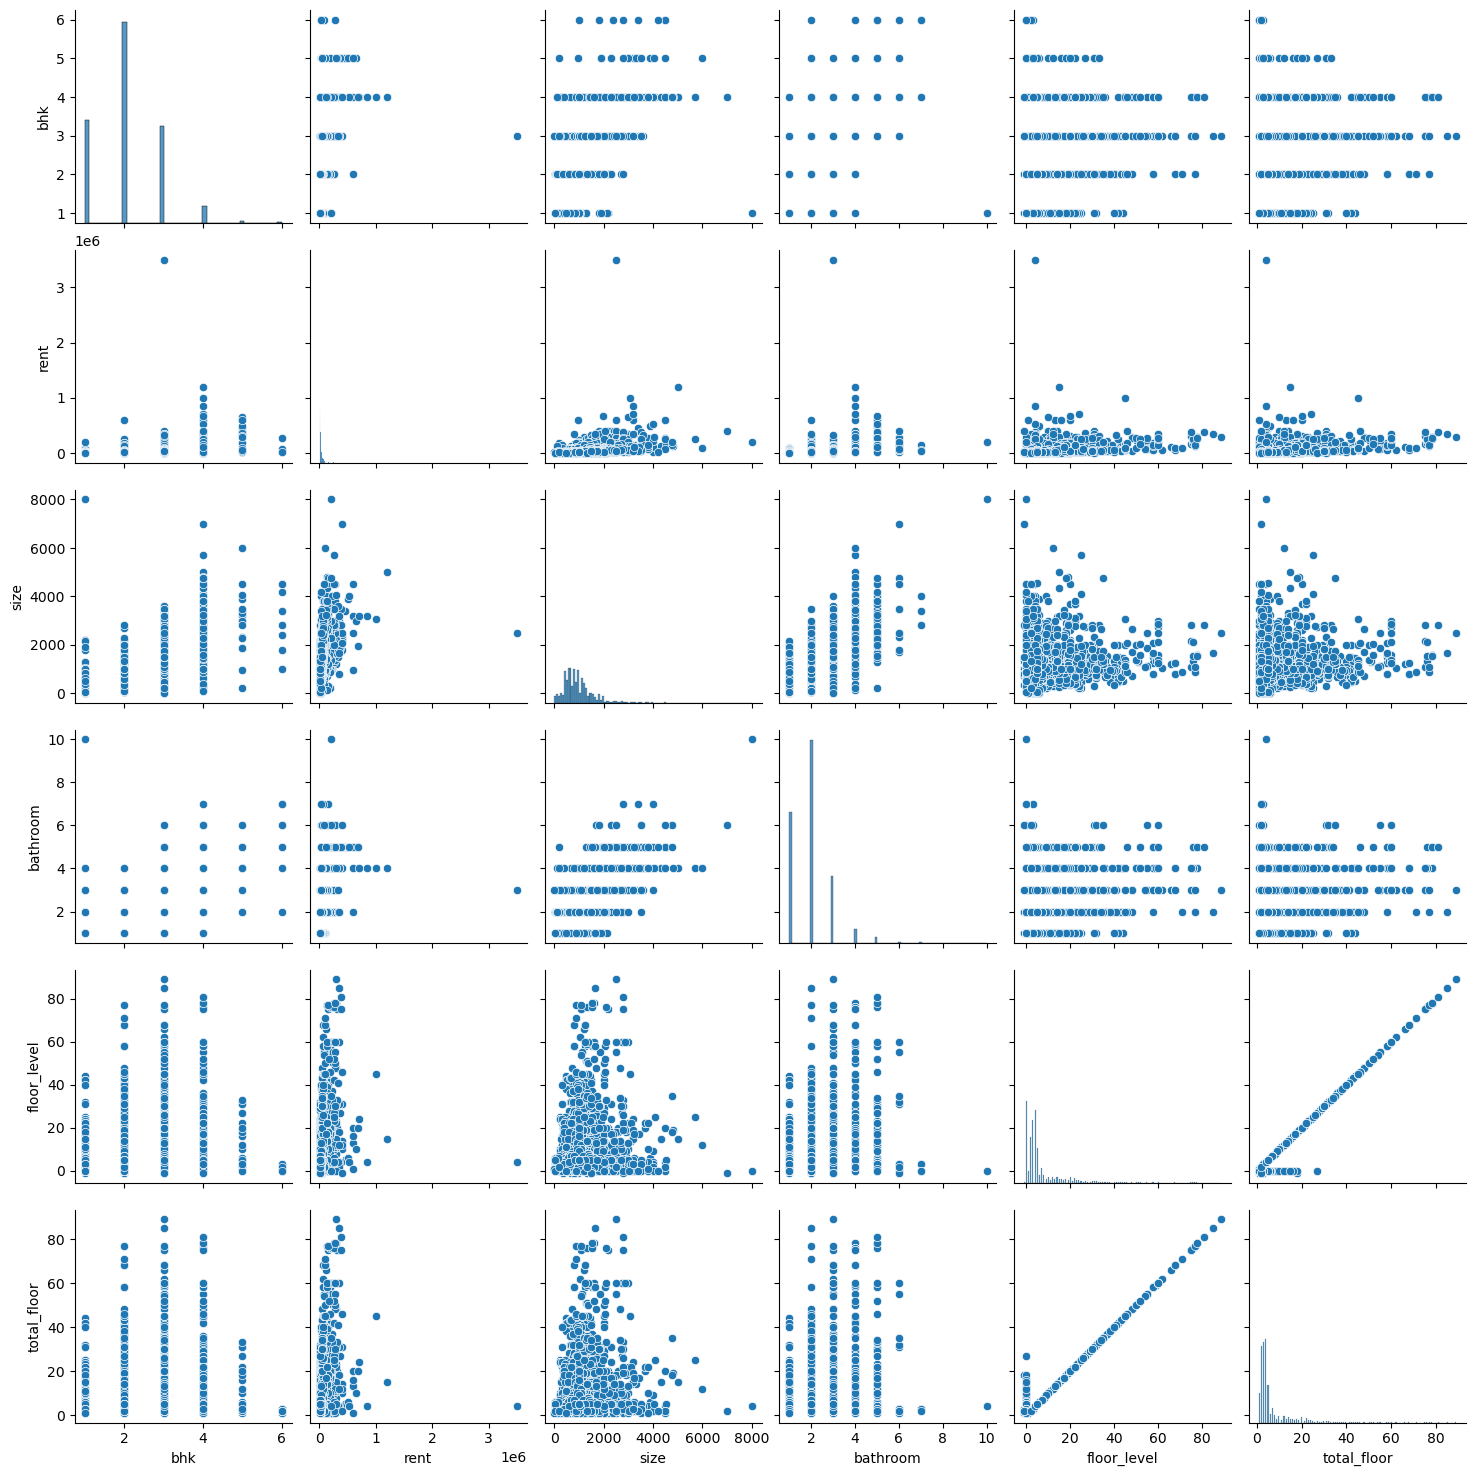

In [115]:
sns.pairplot(df3)

จาก
> 3\. `Independence` : ตัวแปรอิสระไม่เกี่ยวข้องกันมากเกินไป

ตรวจสอบความสัมพันธ์ของตัวแปรอิสระโดยใช้ Pearson's correlation  
<div>
<img src="attachment:Screenshot%202022-11-21%20161419.png" width="400"/>
</div>

In [116]:
df5 = df4.drop('area_locality', axis=1)
df5.corr()

,bhk,rent,size,bathroom,floor_level,total_floor,Carpet Area,Super Area,Bangalore,Chennai,...,Kolkata,Mumbai,Furnished,Semi-Furnished,Unfurnished,Bachelors,Bachelors/Family,Family,Contact Agent,Contact Owner
bhk,1.00,0.37,0.72,0.79,0.25,0.25,0.15,-0.15,-0.09,0.02,...,-0.05,0.02,0.04,0.13,-0.17,0.03,-0.10,0.11,0.23,-0.23
rent,0.37,1.00,0.41,0.44,0.35,0.35,0.22,-0.22,-0.06,-0.08,...,-0.11,0.33,0.11,0.05,-0.13,0.04,-0.08,0.06,0.34,-0.34
size,0.72,0.41,1.00,0.74,0.19,0.19,0.08,-0.08,0.01,0.05,...,-0.10,-0.05,0.05,0.16,-0.21,0.03,-0.09,0.10,0.21,-0.21
bathroom,0.79,0.44,0.74,1.00,0.36,0.36,0.18,-0.18,-0.09,0.02,...,-0.21,0.18,0.08,0.14,-0.20,0.03,-0.12,0.14,0.33,-0.33
floor_level,0.25,0.35,0.19,0.36,1.00,0.99,0.29,-0.29,-0.12,-0.15,...,-0.18,0.58,0.06,0.06,-0.11,0.01,-0.11,0.15,0.47,-0.47
total_floor,0.25,0.35,0.19,0.36,0.99,1.00,0.29,-0.29,-0.12,-0.15,...,-0.17,0.58,0.06,0.06,-0.10,0.01,-0.11,0.15,0.47,-0.47
Carpet Area,0.15,0.22,0.08,0.18,0.29,0.29,1.00,-1.00,-0.10,-0.13,...,0.01,0.37,0.05,0.00,-0.04,0.32,-0.36,0.14,0.56,-0.56
Super Area,-0.15,-0.22,-0.08,-0.18,-0.29,-0.29,-1.00,1.00,0.10,0.13,...,-0.01,-0.37,-0.05,-0.00,0.04,-0.32,0.36,-0.14,-0.56,0.56
Bangalore,-0.09,-0.06,0.01,-0.09,-0.12,-0.12,-0.10,0.10,1.00,-0.23,...,-0.17,-0.24,-0.06,0.18,-0.14,-0.03,0.06,-0.06,-0.12,0.12
Chennai,0.02,-0.08,0.05,0.02,-0.15,-0.15,-0.13,0.13,-0.23,1.00,...,-0.17,-0.24,-0.07,0.03,0.02,-0.03,0.00,0.03,-0.18,0.18


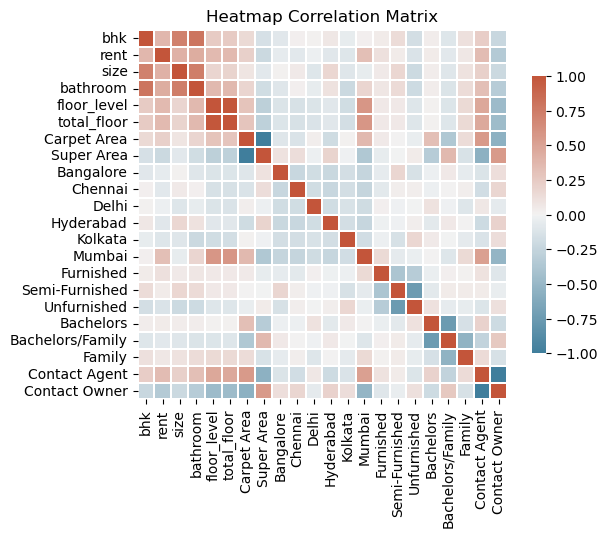

In [117]:
# Define a nice color map for our heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
        data=df5.corr(),  # our correlation matrix
        linewidths=0.3,  # the width of lines separating the matrix squares
        square=True,   # enforce 1:1 ratios among correlation cells
        cmap=cmap,  # use the color map we defined above
        vmax=1,  # define the max of our correlation scale
        vmin=-1, # define the min of our correlation scale
        center=0,  # The value at which the color map is centered about (white)
        cbar_kws={"shrink": .75}  # shrink the scale a bit
    )
# adjust y-axis ticks for legibility
plt.yticks(rotation=0)  
plt.title(f'Heatmap Correlation Matrix')
# show the heatmap
plt.show()

จาก
> 4\. `Normality` : การแจกแจงของตัวแปรตามเป็นแบบโค้งปกติ (Normal Distribution) ที่ทุกค่าของ X

ตรวจสอบการแจกแจงของราคาเช่าบ้าน

/home/ss/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


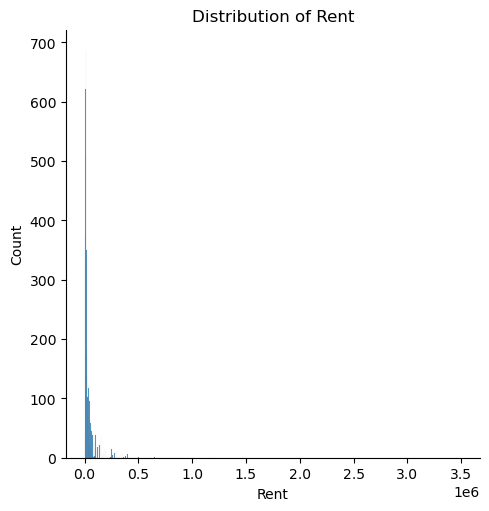

กราฟมีการกระจายตัวแบบโค้งเบ้ลาดขวา


In [118]:
def vis_dist(df, col, lim=False):
    variable = df[col].values
    ax = sns.displot(variable)
    plt.title(f'Distribution of {col}')
    plt.xlabel(f'{col}')
    if lim:
        plt.xlim(0, 4000)
    return plt.show()
vis_dist(df, 'Rent')
print("กราฟมีการกระจายตัวแบบโค้งเบ้ลาดขวา")


เพื่อให้สะดวกต่อการดูการกระจายของข้อมูลที่ชัดขึ้น จึงลดสเกลของกราฟลง

/home/ss/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


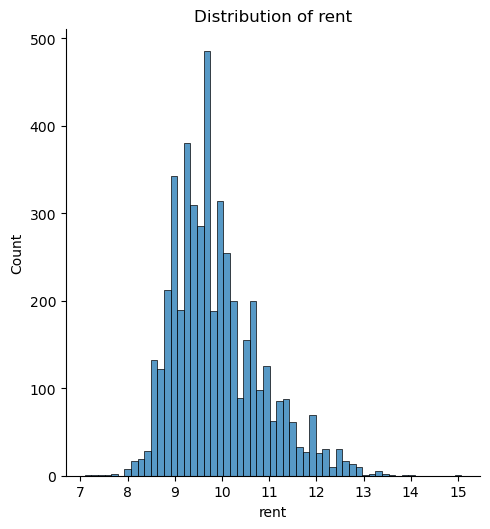

In [119]:
df3['rent'] = np.log1p(df3['rent'])
vis_dist(df3, 'rent')

# 🎓 Training a Linear Regression Model

สมการที่ใช้การทำนายของ Linear Regression คือ  
$$\hat{y} = θ_0x_0 + θ_1x_1 + θ_2x_2 + \ldots + θ_nx_n$$  
โดยที่  
$\hat{y}$: ค่าที่โมเดลทำนายออกมา  
$\theta$: model parameters  
$x$: feature value  
$n$: จำนวน feature ในชุดข้อมูล  
$x_0$: 1 (สำหรับการคูณ vector)  
$\theta_0$: Intercept

สังเกตว่าสมการนี้คือ dot product ระหว่าง θ กับ x จึงสามารถเขียนสมการใหม่ได้ออกมาเป็น
$$\hat{y} = \boldsymbol{x}^T \boldsymbol{\theta}$$

แต่ในการคำนวณจริง เราจำเป็นต้องคำนวณค่า $\hat{y}$ หลายตัวพร้อมกัน  
จึงให้ X เป็น matrix ที่มี $n$ แถวแทนจำนวนชุดข้อมูล และ $i$ คอลัมน์แทนจำนวน feature
$$
\begin{bmatrix}  
x_0^0  & \cdots & x_i^0  \\
\vdots & \ddots & \vdots \\
x_0^n  & \cdots & x_i^n  \\
\end{bmatrix}  
\begin{bmatrix}  
\theta_0 \\
\vdots   \\
\theta_i \\
\end{bmatrix} = 
\begin{bmatrix}  
\hat{y}_0 \\
\vdots  \\
\hat{y}_n \\
\end{bmatrix}  
$$
$$\boldsymbol{\hat{y}} = X\boldsymbol{\theta}$$

# 📌 กำหนดตัวแปรอิสระ X และตัวแปรตาม y

In [120]:
RANDOM_NUMBER = 42
y =df5['rent']
X = df5.drop(['rent'],axis=1)

### Splitting in to Train and Test Dataset

$\;\;\;\;$**แบ่งข้อมูลออกเป็น 2 ชุด**
>1. สำหรับการฝึกโมเดล
>2. สำหรับการทดสอบ

In [121]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn import tree

def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_NUMBER)
    y_train = y_train.ravel()
    y_test = y_test.ravel()
    shape(X_train,'X_train') ; shape(X_test,'X_test') ; shape(y_train,'y_train') ; shape(y_test,'y_test')
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(X, y)

ขนาดข้อมูลของ : "X_train" = (3791, 21)
ขนาดข้อมูลของ : "X_test" = (948, 21)
ขนาดข้อมูลของ : "y_train" = (3791,)
ขนาดข้อมูลของ : "y_test" = (948,)


### ระบุตัวกำหนดในการทำนาย

In [122]:
# select attributes using Random Forest Regressor
def select_feature_dtc(X_train,y_train, selected_estimator):
    # get selector.threshold_
    selector = SelectFromModel(estimator=selected_estimator).fit(X_train, y_train)
    print(f'selector.threshold_ = {selector.threshold_}')

    feature_name = X_train.columns[selector.get_support()]
    print(f'Number of selected features = {feature_name.shape[0]}')

    # put it into a data frame
    d = {'columns': X_train.columns.tolist(),  'support':selector.get_support()}
    df = pd.DataFrame(data=d)
    df = df[df.support ==True]
    df.reset_index(inplace = True, drop=True)
    return df, feature_name

selected_estimator = RandomForestRegressor(random_state=RANDOM_NUMBER)
df, feature_name = select_feature_dtc(X_train, y_train, selected_estimator)
df

selector.threshold_ = 0.047619047619047616
Number of selected features = 3


,columns,support
0,size,True
1,bathroom,True
2,Mumbai,True


# Closed Form Equation

เป็นการคำนวณหาค่า model parameters โดยตรง

โดยเราจะกำหนด cost function แล้วหา model parameter ที่ทำให้ cost function มีค่าน้อยที่สุดที่เป็นไปได้  
cost function ที่จะใช้คือ Mean Squared Error (MSE)
$$MSE(\hat{y}, y) = \frac{1}{n} \sum_{i=1}^{n} (\hat{y}_i-y_i)^2$$
โดยที่  
$\hat{y}$: ข้อมูลที่โมเดลทำนายออกมา  
$y$: ข้อมูลที่แท้จริง  
$n$: จำนวนข้อมูล  
<br>
ซึ่งสามารถจัดรูปใหม่ได้เป็น
$$MSE(\boldsymbol{\hat{y}}, \boldsymbol{y}) = \frac{1}{n} (\boldsymbol{\hat{y}} - \boldsymbol{y})^T(\boldsymbol{\hat{y}} - \boldsymbol{y})$$

แล้วนำ $\boldsymbol{\hat{y}} = X\boldsymbol{\theta}$ มาแทนในสมการ จะได้
$$MSE(X, \boldsymbol{\theta}, \boldsymbol{y}) = \frac{1}{n} (X\boldsymbol{\theta} - \boldsymbol{y})^T(X\boldsymbol{\theta} - \boldsymbol{y})$$


$$\begin{matrix} \text{Vector derivative} \\ \text{(B is a constant matrix)} \end{matrix}$$
$$
\begin{array}{c c c}
\hline
\\ f(x) & \rightarrow & \frac{df}{dx} \\ \\
\hline \\
\boldsymbol{x}^TB & \rightarrow & B \\ 
\boldsymbol{x}^T\boldsymbol{b} & \rightarrow & \boldsymbol{b} \\ 
\boldsymbol{x}^T\boldsymbol{x} & \rightarrow & 2\boldsymbol{x} \\
\boldsymbol{x}^TB\boldsymbol{x} & \rightarrow & 2B\boldsymbol{x} \\
\end{array}
$$
จากตารางสรุป [vector derivative](http://www.gatsby.ucl.ac.uk/teaching/courses/sntn/sntn-2017/resources/Matrix_derivatives_cribsheet.pdf) สำหรับการหา derivative ของ MSE
<br>
เราต้องการหา $\boldsymbol{\theta}$ ที่ทำให้ MSE มีค่าออกมาน้อยที่สุดเท่าที่เป็นไปได้ จึงต้องทำการหา partial derivative ของ MSE เทียบกับ $\boldsymbol{\theta}$

$$  
\def\MSE{MSE(\boldsymbol{\theta})}
\def\parMSE{\frac{\partial{\MSE}}{\partial{\boldsymbol{\theta}}}}
\begin{aligned}
\parMSE &= \frac{\partial}{\partial{\boldsymbol{\theta}}}
\left[\frac{1}{n} (X\boldsymbol{\theta} - \boldsymbol{y})^T(X\boldsymbol{\theta} - \boldsymbol{y})\right] \\

&= \frac{\partial}{\partial{\boldsymbol{\theta}}}
\left[\frac{1}{n} (\boldsymbol{\theta}^TX^T - \boldsymbol{y}^T)(X\boldsymbol{\theta} - \boldsymbol{y})\right] \\

&= \frac{\partial}{\partial{\boldsymbol{\theta}}}
\left[\frac{1}{n} (\boldsymbol{\theta}^TX^TX\boldsymbol{\theta} - \boldsymbol{\theta}^TX^Ty - y^TX\boldsymbol{\theta} + y^Ty)\right] \\

&= \frac{\partial}{\partial{\boldsymbol{\theta}}}
\left[\frac{1}{n} (\boldsymbol{\theta}^TX^TX\boldsymbol{\theta} - \boldsymbol{\theta}^TX^Ty - (y^TX\boldsymbol{\theta})^T + y^Ty)\right] \\

&= \frac{\partial}{\partial{\boldsymbol{\theta}}}
\left[\frac{1}{n} (\boldsymbol{\theta}^TX^TX\boldsymbol{\theta} - \boldsymbol{\theta}^TX^Ty - \boldsymbol{\theta}^TX^Ty + y^Ty)\right] \\

&= \frac{\partial}{\partial{\boldsymbol{\theta}}}
\left[\frac{1}{n} (\boldsymbol{\theta}^TX^TX\boldsymbol{\theta} - 2\boldsymbol{\theta}^TX^Ty + y^Ty)\right] \\

&= \frac{1}{n} \left(2X^TX\boldsymbol{\theta} - 2X^Ty \right) \\

&= \frac{2}{n} \left(X^TX\boldsymbol{\theta} - X^Ty \right) \\
\end{aligned}
$$

จากนั้นหาค่าวิกฤตของ $\theta$ ที่ทำให้ $\parMSE$ เท่ากับ 0
$$
\begin{aligned}
\parMSE &= 0 \\
\frac{2}{n} \left(X^TX\boldsymbol{\theta} - X^Ty \right) &= 0 \\
X^TX\boldsymbol{\theta} - X^Ty &= 0 \\
X^TX\boldsymbol{\theta} &= X^Ty \\
\boldsymbol{\theta} &= (X^TX)^{-1}X^Ty \\
\end{aligned}
$$
สุดท้ายก็จะได้ออกมาเป็น [normal equation](https://eli.thegreenplace.net/2014/derivation-of-the-normal-equation-for-linear-regression)

# สร้างฟังก์ชันในการทำนาย

In [123]:
def test_predict(model,X_train,X_test,y_train,y_test, parameters = None):
    model.fit(X_train, y_train)
    prediction_test = model.predict(X_test)
    print(prediction_test[0:5])
    print(y_test[0:5])
    model_text_list=[];metric_list=[]; score_list=[] ; param_list=[]
    
    # create list of metric to be examined
    metric_functions = [r2_score, r2_score, mean_squared_error,mean_squared_error,mean_absolute_error]
    metric_functions_text = ['R_Squared', 'Adj_R_Squared', 'MSE','RMSE','MAE']
    
    # for loop of each of the 5 metrics
    for metric_function, metric_function_text in zip(metric_functions, metric_functions_text):
        if metric_function_text == 'Adj_R_Squared':
            Adj_r2 = 1 - (1-r2_score(y_test, prediction_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
            model_text_list.append(type(model).__name__);
            metric_list.append(metric_function_text); 
            score_list.append(Adj_r2); 
            param_list.append(parameters)
        elif metric_function_text == 'RMSE':
            rmse = mean_squared_error(y_test, prediction_test, squared=False)
            model_text_list.append(type(model).__name__); 
            metric_list.append(metric_function_text);
            score_list.append(rmse);
            param_list.append(parameters)
        else:
            model_text_list.append(type(model).__name__);
            metric_list.append(metric_function_text);
            score_list.append(metric_function(y_test, prediction_test));
            param_list.append(parameters) 
    
    d = {'model':model_text_list, 'parameters': param_list ,'metric': metric_list, 'test predict score': score_list}
    df = pd.DataFrame(data=d)
    return df

def five_cv_prarm_grid(PARAM_DICT, ESTIMATOR,X_train,y_train):
    sh = HalvingGridSearchCV(ESTIMATOR, PARAM_DICT, cv=10, scoring='neg_mean_absolute_error',min_resources="smallest",random_state=RANDOM_NUMBER).fit(X_train, y_train)
    best_estimator = sh.best_estimator_
    best_param = sh.best_params_
    print(best_estimator)
    print(f"10-CV Best Parameters = {best_param}")
    print(f"10-CV Best Score = {sh.best_score_}")
    return best_estimator, best_param

def cross_validation(model, treated_X, y):
    # drop na columns
    # treated_X = treated_X.dropna(axis=1)
    # train test split
    X_train, X_test, y_train, y_test = split_data(treated_X, y)
    # cross validation
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
    mean = scores.mean() ; std =scores.std()
    print(f"Average neg_mean_absolute_error: {mean}   , Std: {std}")
    print()
    return mean

# Cross Validation เพื่อ Standardisation
K-Fold Cross Validation คือการที่เราแบ่งข้อมูลเป็นจำนวน K ส่วนโดยการในแต่ละส่วนจะต้องมาจากสุ่มเพื่อที่จะให้ข้อมูลของเรากระจายเท่าๆกัน เเล้วนำ Training Data ของเราไปหา Regression Line และทดสอบครับว่าข้อมูลชุดไหนที่ทำให้เส้นของเราทำนายได้ดีที่สุด

In [124]:
model = RandomForestRegressor(random_state=RANDOM_NUMBER)

scaler_minmax = MinMaxScaler()
scaler_std = StandardScaler()
scaler_final = None

X_num = X.astype(int)
print("10 fold cross validation, where the higher the value, the better, this is because the MAE is negated")

# normalisation (min max scalling)
print("normalisation (min max scalling)")
normalized_X = scaler_minmax.fit_transform(X_num)
norm_score = cross_validation(model, normalized_X, y)

# standardisation
print("standardisation")
standardized_X = scaler_std.fit_transform(X_num)
std_score = cross_validation(model, standardized_X, y)

if norm_score> std_score:
    print(f"Normalisation is better than standardisation, where {norm_score}>{std_score}")
    print("Normalisation is chosen")
    scaler_final = scaler_minmax
else:
    print(f"Standardisation is better than normalisation, where {std_score}>{norm_score}")
    print("Standardisation is chosen")
    scaler_final = scaler_std

10 fold cross validation, where the higher the value, the better, this is because the MAE is negated
normalisation (min max scalling)
ขนาดข้อมูลของ : "X_train" = (3791, 21)
ขนาดข้อมูลของ : "X_test" = (948, 21)
ขนาดข้อมูลของ : "y_train" = (3791,)
ขนาดข้อมูลของ : "y_test" = (948,)


Average neg_mean_absolute_error: -11380.063982710137   , Std: 898.569332404535

standardisation
ขนาดข้อมูลของ : "X_train" = (3791, 21)
ขนาดข้อมูลของ : "X_test" = (948, 21)
ขนาดข้อมูลของ : "y_train" = (3791,)
ขนาดข้อมูลของ : "y_test" = (948,)
Average neg_mean_absolute_error: -11399.627524389969   , Std: 912.9805318214599

Normalisation is better than standardisation, where -11380.063982710137>-11399.627524389969
Normalisation is chosen


# ประเมินผลการทำนาย

In [125]:
X_train, X_test, y_train, y_test = split_data(X_num, y)

model = LinearRegression()
pipeline = PMMLPipeline([
    ("scaler", scaler_final),
    ("regressor", model)
])
pipeline.fit(X_train, y_train)

pd.options.display.float_format = '{:,.2f}'.format
LinearRegression_test = test_predict(pipeline, X_train,X_test,y_train,y_test)
LinearRegression_test

ขนาดข้อมูลของ : "X_train" = (3791, 21)
ขนาดข้อมูลของ : "X_test" = (948, 21)
ขนาดข้อมูลของ : "y_train" = (3791,)
ขนาดข้อมูลของ : "y_test" = (948,)
[  5056. -16064.  81984.  12864.   7872.]
[12500  6500 60000 17000  6500]


/home/ss/anaconda3/lib/python3.11/site-packages/sklearn2pmml/pipeline/__init__.py:75: UserWarning: y is missing target field name(s)
  warnings.warn("y is missing target field name(s)")
/home/ss/anaconda3/lib/python3.11/site-packages/sklearn2pmml/pipeline/__init__.py:75: UserWarning: y is missing target field name(s)
  warnings.warn("y is missing target field name(s)")


,model,parameters,metric,test predict score
0,PMMLPipeline,None,R_Squared,0.14
1,PMMLPipeline,None,Adj_R_Squared,0.13
2,PMMLPipeline,None,MSE,"14,519,433,801.62"
3,PMMLPipeline,None,RMSE,"120,496.61"
4,PMMLPipeline,None,MAE,"24,991.60"


# Save model

In [126]:
# Export the model to PMML
sklearn2pmml(pipeline, "linear_regression_model.pmml")